# TP3 - Parte 3: Modelo 2 - Random Forest

Para el segundo modelo, puedo hacer un Random Forest o una red neuronal.

RandomForest, algunas ideas de features:
- Tengo que considerar y hacer si o si interacción entre features, porque lo modelos basados en arboles toman cada columna aislada de las demás y no logran ver estas relaciones.
- Necesito features que aporten mucha información:
  - Hago el BERTweet embedding de 'text' -> 768 features
  - Obtengo lat y long de la location, me va a dar buenas cercanías y después lo puedo usar en el KNN. -> 2 features
  - Hago un freq. encoding de las ubicaciones para tener el valor de qué tan común es una ubicación en el dataset. -> 1 feature
  - Hago un target mean encoding con smoothing de las locations para saber qué tendencia tiene esa ubicacion -> 1 feature
  - Hago un target mean encoding con smoothing de la keyword para saber qué tendencia tiene esa keyword -> 1 feature
  - Hago un freq.de las keywords -> 1 features
  - Hago un target mean de las keywords -> 1 feature
  - Hago una Normalización + producto de las freq y target_mean respectivas para tener uan feature de interacción: feature_combinada=freq_norm×target_mean_norm

Si hago una red neuronal, las features podrían ser similares y también me van a servir. Asique decidí hacer estas features, entrenar un random forest y si le va muy mal tratar de encarar por una red neuronal.

Para XGBoost, me di cuenta que el embedding TF-IDF no estaba dando buenos resultados. Asique lo cambié por un BERTweet embedding, eso se realizó en este colab pero fue movido al collab de [FeatureEngineeringAvanzado](https://colab.research.google.com/drive/1Bw-J2DlBCxO0wMxY0KQ8wTtN_Yu-KIOk?usp=sharing) para mayor prolijidad.

## Imports y descarga de dependencias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from category_encoders import TargetEncoder

## Load de datos:

Cargo los X e Y:

In [ ]:
X_train = pd.read_csv("../data/processed/X_train_procesado.csv", index_col=0)
y_train = pd.read_csv("../data/processed/y_train_procesado.csv", index_col=0)

X_validation = pd.read_csv("../data/processed/X_validation_procesado.csv", index_col=0)
y_validation = pd.read_csv("../data/processed/y_validation_procesado.csv", index_col=0)

X_test = pd.read_csv("../data/processed/X_test_procesado.csv", index_col=0)

Voy a utilizar el embedding que hicimos con BERTweet, como vimos antes:

In [ ]:
df_train_bert = pd.read_csv("../data/processed/df_train_bert.csv", index_col=0)
df_valid_bert = pd.read_csv("../data/processed/df_valid_bert.csv", index_col=0)

In [ ]:
X_train = pd.concat([X_train, df_train_bert], axis=1)
X_validation = pd.concat([X_validation, df_valid_bert], axis=1)

Dropeo los textos porque ya los embedee con BERTweet

In [ ]:
X_train = X_train.drop(columns=["text"])
X_validation = X_validation.drop(columns=["text"])

Y por ultimo, me falta agregar las columnas latitud y longitud que extraímos con Nominatim

In [ ]:
X_validation_latlon = pd.read_csv("../data/processed/X_validation_latlon.csv", index_col=0)
X_train_latlon = pd.read_csv("../data/processed/X_train_latlon.csv", index_col=0)

Y mergeamos latlon con los X correspondientes:

In [ ]:
X_train.head()

,keyword,tweet_length,num_uppercase_letters,num_uppercase_words,num_special_chars,num_digits,standard_location,num_hashtags,num_urls,num_tags,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
id,,,,,,,,,,,,,,,,,,,,,
4392,earthquake,medium_short,40,7,15,5,global edition,1,2,0,...,0.013628,0.263637,-0.014597,-0.107999,0.236785,-0.052586,0.143682,-0.074878,0.089108,0.028698
59,ablaze,medium_long,23,0,22,7,live on webcam,1,4,0,...,0.090665,0.149493,-0.010773,-0.023439,0.312468,0.066056,0.149918,-0.214869,0.089249,-0.181601
799,battle,medium_long,14,0,7,1,United Kingdom,0,1,1,...,-0.000984,0.299295,0.059696,-0.025790,0.006181,0.003387,0.111893,-0.118300,-0.043197,-0.118889
3312,demolished,long,10,0,6,0,Glasgow,0,0,1,...,-0.051511,-0.020962,0.046283,0.036090,0.176024,-0.135693,0.175549,-0.116336,0.021343,-0.180932
4150,drown,medium_long,6,0,11,0,NaN,0,0,3,...,0.121621,0.189743,0.116067,-0.051498,-0.217859,0.015518,0.132276,-0.070130,-0.050150,-0.079486


In [ ]:
X_train_latlon.head()

,lat,lon
id,,
4392,NaN,NaN
59,NaN,NaN
799,54.702354,-3.276575
3312,55.861155,-4.250169
4150,NaN,NaN


In [ ]:
X_train = X_train.merge(X_train_latlon, how="left", left_index=True, right_index=True)

In [ ]:
X_validation = X_validation.merge(X_validation_latlon, how="left", left_index=True, right_index=True)

## ColumnTransformer para RandomForest

### Algunos encodings extras

Voy a generar unos encodings para keyword:
Quiero features que representen relaciones entre variso features ya que esto no puede verlo por si solo el random forest. Asique pensé en computar el ratio de apariciones/target_mean. Pero como vimso en clase 1/2 no es lo mismo que 50/100, por lo tanto quiero agregar también intervalos de confianza del 95%


In [ ]:
train_df = X_train.copy()
train_df['target'] = y_train.values

In [ ]:
global_mean = train_df['target'].mean()
global_mean

np.float64(0.4297208538587849)

In [ ]:
stats_df = train_df.groupby('keyword')['target'].agg(['mean','count','std']).reset_index()
stats_df = stats_df.rename(columns={'mean':'target_mean','count':'apariciones','std':'target_std'})
stats_df

,keyword,target_mean,apariciones,target_std
0,ablaze,0.333333,33,0.478714
1,accident,0.678571,28,0.475595
2,aftershock,0.000000,27,0.000000
3,airplane%20accident,0.833333,30,0.379049
4,ambulance,0.454545,22,0.509647
...,...,...,...,...
216,wounded,0.687500,32,0.470929
217,wounds,0.391304,23,0.499011
218,wreck,0.233333,30,0.430183
219,wreckage,1.000000,32,0.000000


In [ ]:
stats_df.apariciones.describe()

,apariciones
count,221.000000
mean,27.366516
std,4.491058
min,6.000000
25%,25.000000
50%,28.000000
75%,30.000000
max,37.000000


Para no tener intervalos exagerados para keywords con pocas apariciones, voy a aplicar un suavizado para keywords con menos de 20 apariciones (aprox casi todo el primer cuantil):

In [ ]:
k_smooth = 5  # parámetro de suavizado
def smooth_mean(row):
    if row['apariciones'] < 20:
        return (row['apariciones'] * row['target_mean'] + k_smooth * global_mean) / (row['apariciones'] + k_smooth)
    else:
        return row['target_mean']

La formula del suavizado es:
`target_mean_smoothed = (n⋅target_mean+k⋅global_mean)/(n+k)`
Y lo usamos para que si hay una keyword con una única aparición y target 1. Su mean es 1, pero no queremos que el modelo le de a todas las nuevas apariciones un predict de 1. Entonces lo suavizamos acercandolo al target mean global de todo el set de training.

In [ ]:
stats_df['target_mean'] = stats_df.apply(smooth_mean, axis=1)

Por qué no usamos .map()? En este caso, la función smooth_mean necesita mirar varias columnas de la fila (apariciones y target_mean) para decidir si aplica suavizado o no.

Ahora calculamos los IC 95% con la formula encontrada en este [post](https://stackoverflow.com/questions/53519823/confidence-interval-in-python-dataframe).

In [ ]:
z = 1.96
stats_df['ci95_low'] = stats_df['target_mean'] - z * (stats_df['target_std'] / np.sqrt(stats_df['apariciones']))
stats_df['ci95_high'] = stats_df['target_mean'] + z * (stats_df['target_std'] / np.sqrt(stats_df['apariciones']))

In [ ]:
stats_df['ratio'] = stats_df['apariciones'] / stats_df['target_mean']
stats_df['ratio_lower'] = stats_df['apariciones'] / stats_df['ci95_high']
stats_df['ratio_upper'] = stats_df['apariciones'] / stats_df['ci95_low']

In [ ]:
stats_df.head(4)

,keyword,target_mean,apariciones,target_std,ci95_low,ci95_high,ratio,ratio_lower,ratio_upper
0,ablaze,0.333333,33,0.478714,0.170000,0.496667,99.000000,66.442953,194.117647
1,accident,0.678571,28,0.475595,0.502409,0.854734,41.263158,32.758721,55.731527
2,aftershock,0.000000,27,0.000000,0.000000,0.000000,inf,inf,inf
3,airplane%20accident,0.833333,30,0.379049,0.697692,0.968974,36.000000,30.960574,42.998893


Tenemos infs asique los reemplazamos porque dividimos por 0:

In [ ]:
MAX_F = np.finfo(np.float32).max   # ≈ 3.4e38
MIN_F = np.finfo(np.float32).min   # ≈ -3.4e38

stats_df = stats_df.replace([np.inf],  MAX_F)
stats_df = stats_df.replace([-np.inf], MIN_F)

In [ ]:
stats_df.head(4)

,keyword,target_mean,apariciones,target_std,ci95_low,ci95_high,ratio,ratio_lower,ratio_upper
0,ablaze,0.333333,33,0.478714,0.170000,0.496667,9.900000e+01,6.644295e+01,1.941176e+02
1,accident,0.678571,28,0.475595,0.502409,0.854734,4.126316e+01,3.275872e+01,5.573153e+01
2,aftershock,0.000000,27,0.000000,0.000000,0.000000,3.402823e+38,3.402823e+38,3.402823e+38
3,airplane%20accident,0.833333,30,0.379049,0.697692,0.968974,3.600000e+01,3.096057e+01,4.299889e+01


Ahora, podemos agregar estas features a X_train:

In [ ]:
X_train = X_train.join(
    stats_df.set_index("keyword")[["apariciones","target_mean","ratio","ratio_lower","ratio_upper"]],
    on="keyword",
    how="left"
)

Y para validation y test, vamos a usar un apply porque vamos a chequear handlear el caso en que aparezca una keyword nueva con valores default:

In [ ]:
mapping = stats_df.set_index('keyword')[['apariciones','target_mean','ratio','ratio_lower','ratio_upper']].to_dict(orient='index')

In [ ]:
ratio_global = stats_df['ratio'].mean()
ratio_lower_global = stats_df['ratio_lower'].mean()
ratio_upper_global = stats_df['ratio_upper'].mean()

In [ ]:
def map_features(row):
    if row['keyword'] in mapping:
        return pd.Series(mapping[row['keyword']])
    else:
        # keywords nuevas
        return pd.Series({
            'apariciones': 0,
            'target_mean': global_mean,
            'ratio': ratio_global,
            'ratio_lower': ratio_lower_global,
            'ratio_upper': ratio_upper_global
        })

In [ ]:
X_validation_feats = X_validation.apply(map_features, axis=1)
X_validation_feats.head(2)

,apariciones,target_mean,ratio,ratio_lower,ratio_upper
id,,,,,
8266,29.0,0.655172,44.263158,34.888038,60.528345
10724,30.0,0.233333,128.571429,77.464861,377.860880


In [ ]:
X_validation = pd.concat([X_validation, X_validation_feats], axis=1)

In [ ]:
X_test_feats = X_test.apply(map_features, axis=1)
X_test_feats.head(2)

,apariciones,target_mean,ratio,ratio_lower,ratio_upper
id,,,,,
0,0.0,0.429721,3.079478e+36,3.079478e+36,3.079478e+36
2,0.0,0.429721,3.079478e+36,3.079478e+36,3.079478e+36


In [ ]:
X_test = pd.concat([X_test, X_test_feats], axis=1)

Como quiero volver a reutilizar estos encodings en otros colabs, voy a guardar los feats:

### Persistiendo encodings de keyword

Extraemos las columnas nueva de X_train y persistimos los dataframes:

In [ ]:
X_train_feats = X_train[["apariciones","target_mean","ratio","ratio_lower","ratio_upper"]]
X_train_feats.head(2)

,apariciones,target_mean,ratio,ratio_lower,ratio_upper
id,,,,,
4392,32.0,0.812500,39.384615,33.687747,47.400403
59,33.0,0.333333,99.000000,66.442953,194.117647


In [ ]:
X_train_feats.to_csv("../data/processed/X_train_keyword_features.csv", index=True)

In [ ]:
X_validation_feats.to_csv("../data/processed/X_validation_keyword_features.csv", index=True)

In [ ]:
X_test_feats.to_csv("../data/processed/X_test_keyword_features.csv", index=True)

### Ahora sí: ColumnTransformer

Catalogo las columnas para más facilidad a la hora de recordar cómo transformar cáda una:

In [ ]:
X_train.columns[:20]

Index(['keyword', 'tweet_length', 'num_uppercase_letters',
       'num_uppercase_words', 'num_special_chars', 'num_digits',
       'standard_location', 'num_hashtags', 'num_urls', 'num_tags',
       'prop_digits', 'prop_words', 'bert_0', 'bert_1', 'bert_2', 'bert_3',
       'bert_4', 'bert_5', 'bert_6', 'bert_7'],
      dtype='object')

In [ ]:
berts = [f"bert_{i}" for i in range(0,768)]

In [ ]:
latlon = ["lat","lon"]

In [ ]:
categorical_keyword = ["keyword"]
categorical_tweetlen = ["tweet_length"]
categorical_location = ["standard_location"]
numerical_cols = [
  "num_uppercase_letters",
  "num_uppercase_words",
  "num_special_chars",
  "num_digits",
  "num_hashtags",
  "num_urls",
  "num_tags",
  "prop_digits",
  "prop_words",
  "lat",
  "lon",
  'apariciones',
  'target_mean',
  'ratio',
  'ratio_lower',
  'ratio_upper'
]

###
# Falta normalizar las columnas? Tengo lat y long con valores bastante grandes.
# Random Forest no necesita normalización. Si hago una red neuronal entonces si.
###

In [ ]:
len(berts + categorical_keyword + categorical_tweetlen + categorical_location + numerical_cols)

787

In [ ]:
set(X_train.columns) - set(berts + categorical_keyword + categorical_tweetlen + categorical_location + numerical_cols)

set()

In [ ]:
def frequency_encode(X):
    s = pd.Series(X.iloc[:,0])
    freq = s.value_counts(normalize=True)
    return s.map(freq).to_frame()

freq_encoder = FunctionTransformer(frequency_encode, feature_names_out="one-to-one")

In [ ]:
preprocessor_rf = ColumnTransformer([
    ("tweetlen_ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_tweetlen),
    ("location_fe", freq_encoder, categorical_location),
    ("location_tme", TargetEncoder(handle_unknown='value', handle_missing='value'), categorical_location),
    ("keyword_fe", freq_encoder, categorical_keyword),
    ("keyword_tme", TargetEncoder(handle_unknown='value', handle_missing='value'), categorical_keyword),
    ("numerical_cols", "passthrough", numerical_cols),
], remainder="passthrough") # Hago passthrough de lat, long, BERTweets embedding y los features de ratio.


Vamos a hacer una predicción sin buscar hiperparámetros para ver qué score obtenemos:

In [ ]:
rf = RandomForestClassifier(random_state=68, verbose=1)

In [ ]:
X_train_transformed = preprocessor_rf.fit_transform(X_train, y_train)

In [ ]:
X_validation_transformed = preprocessor_rf.transform(X_validation)

In [ ]:
y_train.values.ravel()

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
X_train_transformed

array([[ 0.        ,  0.        ,  1.        , ..., -0.07487777,
         0.08910789,  0.0286982 ],
       [ 0.        ,  1.        ,  0.        , ..., -0.21486859,
         0.08924857, -0.18160075],
       [ 0.        ,  1.        ,  0.        , ..., -0.11830024,
        -0.04319663, -0.11888946],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.12377842,
         0.18206002, -0.06257236],
       [ 0.        ,  0.        ,  0.        , ..., -0.05885799,
        -0.08387928, -0.04059251],
       [ 0.        ,  0.        ,  1.        , ..., -0.11839632,
        -0.1321485 , -0.16116357]])

In [ ]:
rf.fit(X_train_transformed, y_train)

In [ ]:
y_train_pred = rf.predict(X_train_transformed)
y_validation_pred = rf.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
f1_train = f1_score(y_train, y_train_pred, average='weighted')
f1_val = f1_score(y_validation, y_validation_pred, average='weighted')
gap = f1_train - f1_val

print(f"Modelo 6: F1 train = {f1_train:.4f}, F1 val = {f1_val:.4f}, gap = {gap:.4f}")

Modelo 6: F1 train = 0.9984, F1 val = 0.7824, gap = 0.2160


Tenemos una predicción bastante buena de forma inicial, que casi nos da 0.79. Hay que ajustarla con busqueda de hiperparámetros.

## RandomSearch rápida para ver el comportamiento:

In [ ]:
parametros_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

In [ ]:
rs_rf = RandomizedSearchCV(estimator=rf, param_distributions=parametros_rf,
                           n_iter=2, cv=5, scoring='f1', random_state=68, n_jobs=-1, verbose=1000)

In [ ]:
rs_rf.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    8.9s


building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   38.8s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:  1.5min


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=68, verbose=2),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=68, scoring='f1', verbose=1000)

In [ ]:
model = rs_rf.best_estimator_

In [ ]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 68,
 'verbose': 2,
 'warm_start': False}

In [ ]:
y_train_pred_rs = model.predict(X_train_transformed)
y_validation_pred_rs = model.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


In [ ]:
f1_train_rs = f1_score(y_train, y_train_pred_rs, average='weighted')
f1_val_rs = f1_score(y_validation, y_validation_pred_rs, average='weighted')
gap = f1_train_rs - f1_val_rs

print(f"Modelo 6: F1 train = {f1_train_rs:.4f}, F1 val = {f1_val_rs:.4f}, gap = {gap:.4f}")

Modelo 6: F1 train = 0.9890, F1 val = 0.7857, gap = 0.2033


## RandomSearch más extensa

Excelente score de casi 0.79 en validación. Voy a hacer un random search mayor para ver el resultado:

Por redondeo, haremos 100 iteraciones de RandomSearch y según el score quizás luego apliquemos algún ajuste extra con Grid, pero si superamos el 0.8 en validation no será necesario.

In [ ]:
rs_rf_ext = RandomizedSearchCV(estimator=rf, param_distributions=parametros_rf,
                           n_iter=50, cv=5, scoring='f1', random_state=13, n_jobs=-1, verbose=1000)

In [ ]:
rs_rf_ext.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   57.6s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   58.0s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=68, verbose=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=13, scoring='f1', verbose=1000)

In [ ]:
model_ext = rs_rf_ext.best_estimator_

In [ ]:
model_ext.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 68,
 'verbose': 1,
 'warm_start': False}

In [ ]:
y_train_pred_rs_ext = model_ext.predict(X_train_transformed)
y_validation_pred_rs_ext = model_ext.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
f1_train_rs_ext = f1_score(y_train, y_train_pred_rs_ext, average='weighted')
f1_val_rs_ext = f1_score(y_validation, y_validation_pred_rs_ext, average='weighted')
gap = f1_train_rs_ext - f1_val_rs_ext

print(f"Modelo rs_ext: F1 train = {f1_train_rs_ext:.4f}, F1 val = {f1_val_rs_ext:.4f}, gap = {gap:.4f}")

Modelo 6: F1 train = 0.9967, F1 val = 0.7845, gap = 0.2122


Mejoró F1 en train, pero en validation no. Estamos teniendo mucho overfitting. Voy a disminuir la cantidad de features para ver si puedo disminuir el overfitting:

## GridSearch para bajar el overfitting

#### Probando con menos features:

In [ ]:
# Elimino las fetures del transformer que se estan repitiendo
preprocessor_rf_2 = ColumnTransformer([
    ("tweetlen_ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_tweetlen),
    #("location_fe", freq_encoder, categorical_location),
    #("location_tme", TargetEncoder(handle_unknown='value', handle_missing='value'), categorical_location),
    #("keyword_fe", freq_encoder, categorical_keyword),
    #("keyword_tme", TargetEncoder(handle_unknown='value', handle_missing='value'), categorical_keyword),
    ("numerical_cols", "passthrough", numerical_cols),
], remainder="passthrough") # Hago passthrough de lat, long, BERTweets embedding y los features de ratio.

In [ ]:
X_train_transformed_2 = preprocessor_rf_2.fit_transform(X_train, y_train)

In [ ]:
X_validation_transformed_2 = preprocessor_rf_2.transform(X_validation)

In [ ]:
rs_rf_2 = RandomizedSearchCV(estimator=rf, param_distributions=parametros_rf,
                           n_iter=2, cv=5, scoring='f1', random_state=68, n_jobs=-1, verbose=1000)

In [ ]:
rs_rf_2.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   47.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=68, verbose=1),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=68, scoring='f1', verbose=1000)

In [ ]:
model_2 = rs_rf_2.best_estimator_

In [ ]:
model_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 68,
 'verbose': 1,
 'warm_start': False}

In [ ]:
y_train_pred_rs_2 = model_2.predict(X_train_transformed)
y_validation_pred_rs_2 = model_2.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


In [ ]:
f1_train_rs_2 = f1_score(y_train, y_train_pred_rs_2, average='weighted')
f1_val_rs_2 = f1_score(y_validation, y_validation_pred_rs_2, average='weighted')
gap = f1_train_rs_2 - f1_val_rs_2

print(f"RF_2: F1 train = {f1_train_rs_2:.4f}, F1 val = {f1_val_rs_2:.4f}, gap = {gap:.4f}")

RF_2: F1 train = 0.9890, F1 val = 0.7857, gap = 0.2033


Esto no tuvo mucha mejora respecto al Random Forest con todas las columnas, asique decidí descartarlo y seguir con lo anterior.

#### Haciendo el modelo más restrictivo:

In [ ]:
model_ext.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 68,
 'verbose': 1,
 'warm_start': False}

Voy a forzar al menos 2 min samples leaf y subir min_samples_split para que se creen nodos solo con información suficiente en vez de ruido.

In [ ]:
parametros_rf_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [2, 4],
    'max_features': ['log2'],
}

In [ ]:
parametros_rf_grid_2 = {
    'n_estimators': [200],
    'max_depth': [10, 12, 15],
    'min_samples_split': [25, 30],
    'min_samples_leaf': [3, 4],
    'max_features': ['log2'],
}
# Puntaje obtenido:
# RandomForest con GridSearch: F1 train = 0.9267, F1 val = 0.7867, gap = 0.1400

In [ ]:
parametros_rf_grid_3 = {
    'n_estimators': [250, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [28, 30],
    'min_samples_leaf': [4, 5],
    'max_features': ['log2'],
}
# Puntaje obtenido:
# RandomForest con GridSearch: F1 train = 0.9413, F1 val = 0.7923, gap = 0.1490
# Superamos el 0.79 en validation. Los parámetros que devolvió GridSearch fueron:
# """
#  {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 12,
#  'max_features': 'log2',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 4,
#  'min_samples_split': 28,
#  'min_weight_fraction_leaf': 0.0,
#  'monotonic_cst': None,
#  'n_estimators': 250,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 68,
#  'verbose': 1,
#  'warm_start': False}
#  """

In [ ]:
parametros_rf_grid_4 = {
    'n_estimators': [275],
    'max_depth': [10, 11],
    'min_samples_split': [30],
    'min_samples_leaf': [4, 5],
    'max_features': ['log2'],
}
# RandomForest con GridSearch: F1 train = 0.8861, F1 val = 0.7798, gap = 0.1063
# {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 10,
#  'max_features': 'log2',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 4,
#  'min_samples_split': 30,
#  'min_weight_fraction_leaf': 0.0,
#  'monotonic_cst': None,
#  'n_estimators': 275,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 68,
#  'verbose': 1,
#  'warm_start': False}

In [ ]:
parametros_rf_grid_5 = {
    'n_estimators': [400],
    'max_depth': [8],
    'min_samples_split': [28, 30],
    'min_samples_leaf': [4],
    'max_features': ['log2'],
}
# RandomForest con GridSearch: F1 train = 0.9193, F1 val = 0.7916, gap = 0.1277

In [ ]:
rs_rf_grid = GridSearchCV(estimator=rf, param_grid=parametros_rf_grid_5,
                           cv=5, scoring='f1', n_jobs=-1, verbose=1000)

In [ ]:
rs_rf_grid.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   16.7s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=68, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8], 'max_features': ['log2'],
                         'min_samples_leaf': [4], 'min_samples_split': [30, 32],
                         'n_estimators': [300, 400]},
             scoring='f1', verbose=1000)

In [ ]:
model_grid = rs_rf_grid.best_estimator_

In [ ]:
model_grid.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 68,
 'verbose': 1,
 'warm_start': False}

In [ ]:
y_train_pred_gs = model_grid.predict(X_train_transformed)
y_validation_pred_gs = model_grid.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
f1_train_gs = f1_score(y_train, y_train_pred_gs, average='weighted')
f1_val_gs = f1_score(y_validation, y_validation_pred_gs, average='weighted')
gap = f1_train_gs - f1_val_gs

print(f"RandomForest con GridSearch: F1 train = {f1_train_gs:.4f}, F1 val = {f1_val_gs:.4f}, gap = {gap:.4f}")

RandomForest con GridSearch: F1 train = 0.8884, F1 val = 0.7828, gap = 0.1056


Después de mucho buscar mejorar los hiperparámetros, no logré encontrar un modelo que alcance 0.8. Entonces empecé a pensar que probablemente el error sea una cuestión de que las features tampoco son tan buenas para el modelo. Mirando la feature importance podemos ver que las features no tienen tanta importancia en la predicción y por lo tanto generan ruido que evita que el modelo mejore.

In [ ]:
feature_names = preprocessor_rf.get_feature_names_out()

In [ ]:
len(feature_names), len(model_grid.feature_importances_)

(792, 792)

In [ ]:
feature_names = preprocessor_rf.get_feature_names_out()
ct = preprocessor_rf

importances = model_grid.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp.head(20))

                             feature  importance
20       numerical_cols__target_mean    0.046005
7               keyword_tme__keyword    0.039754
21             numerical_cols__ratio    0.032360
5    location_tme__standard_location    0.030458
22       numerical_cols__ratio_lower    0.027500
23       numerical_cols__ratio_upper    0.016836
372              remainder__bert_348    0.012769
16        numerical_cols__prop_words    0.007484
168              remainder__bert_144    0.007062
277              remainder__bert_253    0.006969
329              remainder__bert_305    0.006822
148              remainder__bert_124    0.006305
146              remainder__bert_122    0.005794
697              remainder__bert_673    0.005460
459              remainder__bert_435    0.005319
15       numerical_cols__prop_digits    0.005070
11        numerical_cols__num_digits    0.004609
622              remainder__bert_598    0.004554
133              remainder__bert_109    0.004490
471              rem

### Mejor modelo:

Nos queda entonces quedarnos con el mejor modelo que pudimos obtener según el score en validation:

Hiperparametros:
```
{'bootstrap': True,
'ccp_alpha': 0.0,
'class_weight': None,
'criterion': 'gini',
'max_depth': 12,
'max_features': 'log2',
'max_leaf_nodes': None,
'max_samples': None,
'min_impurity_decrease': 0.0,
'min_samples_leaf': 4,
'min_samples_split': 28,
'min_weight_fraction_leaf': 0.0,
'monotonic_cst': None,
'n_estimators': 250,
'n_jobs': None,
'oob_score': False,
'random_state': 68,
'verbose': 1,
'warm_start': False}
```
Scores: F1 train = 0.9413, F1 val = 0.7923, gap = 0.1490

In [ ]:
rf_best = RandomForestClassifier(
    bootstrap = True,
    ccp_alpha = 0.0,
    class_weight = None,
    criterion = 'gini',
    max_depth = 12,
    max_features = 'log2',
    max_leaf_nodes = None,
    max_samples = None,
    min_impurity_decrease = 0.0,
    min_samples_leaf = 4,
    min_samples_split = 28,
    min_weight_fraction_leaf = 0.0,
    monotonic_cst = None,
    n_estimators = 250,
    n_jobs = None,
    oob_score = False,
    random_state = 68,
    verbose = 1,
    warm_start = False
)

In [ ]:
rf_best.fit(X_train_transformed, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   22.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   27.1s finished


RandomForestClassifier(max_depth=12, max_features='log2', min_samples_leaf=4,
                       min_samples_split=28, n_estimators=250, random_state=68,
                       verbose=1)

In [ ]:
y_pred_best = rf_best.predict(X_validation_transformed)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


In [ ]:
f1_val_best = f1_score(y_validation, y_pred_best, average="weighted")
print(f"Best RandomForest Score: F1 validation = {f1_val_best:.4f}")

Best RandomForest Score: F1 validation = 0.7923


## Prediciendo Test

Siendo 0.7923 en validation el mejor score obtenido hasta ahora, voy a usar mi Random Forest para hacer una predicción para la competencia de Kaggle

In [ ]:
X_test = pd.read_csv("../data/processed/X_test_procesado.csv", index_col=0)

In [ ]:
df_test_bert = pd.read_csv("../data/processed/df_test_bert.csv", index_col=0)
X_test = pd.concat([X_test, df_test_bert], axis=1)
X_test = X_test.drop(columns=["text"])

X_test_latlon = pd.read_csv("../data/processed/X_test_latlon.csv", index_col=0)
X_test = X_test.merge(X_test_latlon, how="left", left_index=True, right_index=True)

In [ ]:
X_test_feats = X_test.apply(map_features, axis=1)
X_test_feats.head(2)

,apariciones,target_mean,ratio,ratio_lower,ratio_upper
id,,,,,
0,0.0,0.429721,3.079478e+36,3.079478e+36,3.079478e+36
2,0.0,0.429721,3.079478e+36,3.079478e+36,3.079478e+36


In [ ]:
X_test = pd.concat([X_test, X_test_feats], axis=1)

In [ ]:
X_test_transformed = preprocessor_rf.transform(X_test)

In [ ]:
y_pred_test = rf_best.predict(X_test_transformed)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished


In [ ]:
submit = pd.DataFrame(y_pred_test, columns=['target'], index = X_test.index)

In [ ]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3263 entries, 0 to 10875
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  3263 non-null   int64
dtypes: int64(1)
memory usage: 51.0 KB


In [ ]:
submit.to_csv("../data/processed/submit_random_forest.csv", index=True)

Ahora subimos el submit a Kaggle y vemos el puntaje obtenido fue:
> **Score Random Forest: 0.79528**

Recordamos que el score obtenido por el baseline fue: 0.78884.

Finalmente, a ultimo hora antes de la entrega obtuve un puntaje de 0.8 en el modelo de XGBoost ya habiendo realizado este submit. Asique tuve que realizar otro que se puede ver en el colab correspondiente.



## TP3 - Parte 4: Consignas Adicionales

Las demás consignas adicionales se pueden visualizar en este [colab](https://colab.research.google.com/drive/1CHardiEiCLslyMerumYiwY0SBgK-c1lt?usp=drive_link). Pero una de las elegidas fue:

Graficar y analizar, para alguno de los modelos de la parte III, los siguientes resultados (1 punto):
- Curva ROC, explicando la selección de corte.
- Feature importance.
- Matriz de confusión.

 Por lo tanto, elegí hacer esto para mi modelo RandomForest.

### 2. Curva ROC, Feature Importance y Matriz de Confusion

### Curva ROC

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


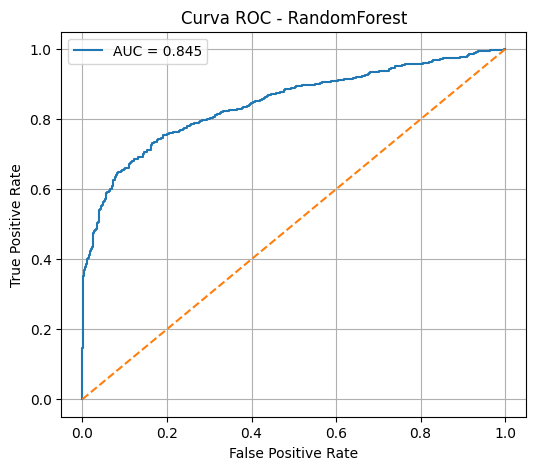

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = rf_best.predict_proba(X_validation_transformed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_validation, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - RandomForest")
plt.legend()
plt.grid(True)
plt.show()


Para la selección de corte. Extraemos todos los thresholds que generan puntos en la ROC. Luego, usamos una métrica para elegir el punto de corte que la maximice.

### Graficando feature importance:

In [1]:
import plotly.graph_objs as go

In [ ]:
feature_names = preprocessor_rf.get_feature_names_out()
ct = preprocessor_rf

df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

df_importances = df_importances.sort_values(by='Importance', ascending=False)

df_importances = df_importances.head(25)

fig = go.Figure([go.Bar(
    x=df_importances['Feature'],
    y=df_importances['Importance'],
    marker=dict(
        color=df_importances['Importance'],
        colorscale='Blues',
        showscale=True
    )
)])

fig.update_layout(
    title='XG Boost - Feature Importance',
    xaxis_title='Features',
    yaxis_title='Importance',
    xaxis_tickangle=-45
)


fig.show()

En este caso, podemos ver que los embeddings de target mean que usamos y los ratios fueron bastantes buenos predictores para el modelo XGBoost, pero las columnas del embedding BERT no aportaban tanto y hacían algo de ruido.

En conclusión, creo que para obtener un mejor score necesitaría hacer una mejor extracción de features y quizás no tantas features que aporten ruido. Me sorprendio ver que ni la latitud ni la longitud aparecen como features importantes, pero sí la Target Mean de la standard location.

### Graficando la matriz de confusión:

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred_best

array([1, 0, 1, ..., 1, 0, 0])

In [ ]:
cm = confusion_matrix(y_validation, y_pred_best)
cm

array([[801,  68],
       [239, 415]])

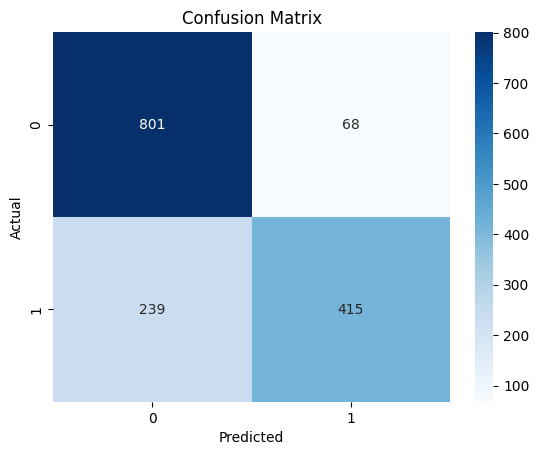

In [ ]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

El mayor problema que estamos teniendo en nuestras predicciones podemos ver que son los falsos negativos. Con una recall de clase positiva del 63,5% que no es algo tan bueno.